# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from random import randint
from random import choice

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.cluster import KMeans
from skimage.transform import radon

import cv2 
import imutils

# For the sake of easy checking on the way - visualize fnc

In [2]:
def visualize(img) -> "draws the image" :
    plt.imshow(img, cmap=cm.gray)

# The generator function : 

Firsly we define generator for a single square : 
* Padding means how much space should be left from the edges 
* img_size - self explanatory 
* It outputs the pair of (sinogram, and image)
* To generate sinogram we can either use : skimage.transform import radon or my own defined sinogram_fnc

2nd function is our entire data generator function
* It loops over the single square generator n times
* It transforms the data into tensors that fit our model [to fit CNN, we need to have dimensions : ( nr of data points *nr of channels * img_size * img_size ) ]  && for some reason we have to cast the data into float32 [ otherwise called "double" ]


3rd function is own_sinogram function : 
* Rotates over the image and saves the x-rays to sinogram array, which it later outputs 

In [3]:
def single_square_data_generator(img_size = 64, # size of the img
                                 padding = 10, # the number of MINIMUM of black spaces around or square - so that it doesnt get cut during rotation
                                 own_sinogram_fnc = False,
                                     ) -> " (sinogram ,image) tuple " :


    img = np.zeros((img_size,img_size)) # create an empty image
    square_size = randint(3+padding,img_size-3-padding) # generate a random size of a square side
    x = randint(1,64-square_size-padding) # left starting point
    y = randint(1,64-square_size-padding) # up starting point
    
    # We got starting point and size of square, now, draw it ! :
    for i in range(square_size) : 
        for j in range(square_size) : 
            img[x+i,y+j] = 1 
            
    
    #Generate sinogram, either with the library or from own method :
    if own_sinogram_fnc :
        sinogram = sinogram_fnc(img)
    else : 
        sinogram = radon(img) 
        
    return (sinogram, img)


def square_data_generator(n : "number of data to be generated",
                          img_size : "size of the square's side",
                          ) -> " (x,y) where x - list of sinograms, y - list of corresponding images" :

    x, y = [], []    
    for _ in range(n):
        sinogram, img = single_square_data_generator(img_size)
        x.append(sinogram)
        y.append(img)
        
    x = np.array(x)
    y = np.array(y)
    
    #### To make it fit the NN we need to transform these to tensors, change their dimensions, and cast into double [float32]
    x = torch.from_numpy(x)
    x = x.view(-1,1,64,180)
    x = x.to(dtype=torch.float32)
    
    return (x,y)



# My own sinogram function : 
def sinogram_fnc(img):
    side_size = img.shape[1]
    
    sinogram = np.zeros((side_size,180)) 
    for i in range(180):
        sinogram[: ,i] = np.sum(img, axis = 0)
        img = imutils.rotate(img,1)
    
    img = imutils.rotate(img,180)
    return sinogram

# Examples with visualization : 

In [34]:
sinogram, img = square_data_generator(1,64) 

In [35]:
print("sinogram.shape : {}".format(sinogram.shape))
print("img.shape : {}".format(img.shape))

sinogram.shape : torch.Size([1, 1, 64, 180])
img.shape : (1, 64, 64)


#### As we can see the shapes are "a bit weird" since they are made so to fit the model, to visualize and play with them let's make them into 2 dimensions :

img.shape : (64, 64)


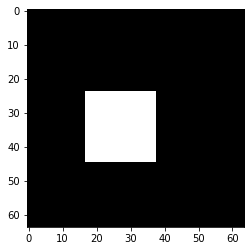

In [36]:
img = img[0]
print("img.shape : {}".format(img.shape))
visualize(img)

sinogram.shape : torch.Size([64, 180])


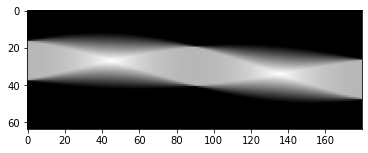

In [37]:
sinogram = sinogram[0,0]
print("sinogram.shape : {}".format(sinogram.shape))
visualize(sinogram)

##### In comparison, sinogram from my own fnc : 

own_sinogram.shape : (64, 180)


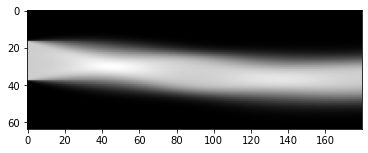

In [38]:
own_sinogram = sinogram_fnc(img)
print("own_sinogram.shape : {}".format(own_sinogram.shape))
visualize(own_sinogram)

#### As we can see : sinograms vary a bit, it's most likely because we used [ me vs sckit ] different libraries for rotations and readthroughts.  

Therefore maybe it's better to use the same method for reconstruction as is used for data generation ?

------------------------------------------------------------------------------------------------------------------------

# Reconstruction algorithm & example : 

#### Reconstructing from the 2 right angles : 

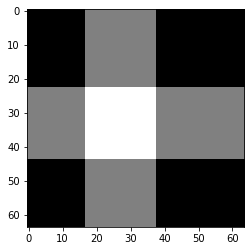

In [41]:
#Get the right angles : 0, 90
angle_0 = sinogram[:,0]
angle_90 = sinogram[:,90]

# These angles are isngle arrays of size 64 [ a side look x-ray like on the data]
# We want to add them across and create an image - therefore to do in numpy we add arrays of size [64,1] to [1,64] and we get array 64 x 64 
angle_90 = angle_90.view(-1,1).numpy()
angle_0 = angle_0.view(1,-1).numpy()

# Because it only gives the right answer when i flip it ? idk why !! 
angle_90 = np.flip(angle_90)
#angle_0 = np.flip(angle_0)

reconstructed = (angle_0 + angle_90)
visualize(reconstructed)

# The Full Reconstruction algorithm : 


* First we define **add_info function** - it add the information to our[at the first step empty] array by rotating the array by x degrees, and then later adding the x-ray information to it


* Then we define reconstruct function which iterates over all of our x-rays scans[ here called projections] and updates the information


* Worth remembering that rotate function rotates by x angles, not to x angles !! 


* I decided to store the information about the angle in form of dictionary { angle : x_ray }

In [42]:
def add_info(img, # Input image
             x,   # The angle number 
             y,   # The sinogram angle's list [ passed as a tensor ]
            ) -> "updated img" : 
    
    # Step 1 - Rotate the image 
    img = imutils.rotate(img, x)
    
    # Step 2 - Update using the array values
    img = img  + y.view(1,-1).numpy()
    img = imutils.rotate(img, -x)
    return img



def reconstruct(size, #size of a image
                projections, # Projections should be a dict in form : {angle : [array of values]}
               ) -> "Outputs a reconstructed image" :
    
    reconstructed_img = np.zeros((size,size)) # create an empty image
    
    # Iterate over all of our information  :
    for x, y in projections.items():
        reconstructed_img = add_info(reconstructed_img, x, y) # x - angle_nr, y - list 
        
    return imutils.rotate(reconstructed_img,90)

#### Example with 2 right angles : 

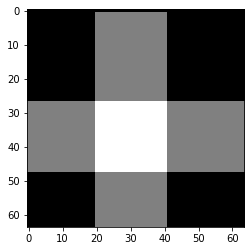

In [44]:
angle_0 = sinogram[:,0]
angle_90 = sinogram[:,90]

dict_info = {0 : angle_0, 90 : angle_90}
visualize(reconstruct(64,dict_info))

#### As we can see it works, but not exactly the way it should, and unluckily it gets even worse for 180 angles [ the entire sinogram ] :

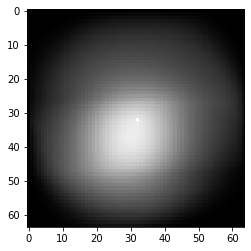

In [45]:
dict_info = {i : sinogram[:,i] for i in range(180)}
reconstructed = reconstruct(64,dict_info)
visualize(reconstructed)

### As we can see the reconstruction isn't exactly the best, and i find it hard to figure out why

In the next part i try to visualize pixels which are over some threshold [ maximum of the entire image array ]

np.amax(reconstructed) : 42.0


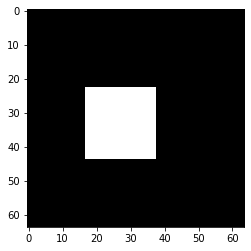

In [57]:
print("np.amax(reconstructed) : {}".format(np.amax(reconstructed)))
binary_img = np.where(reconstructed>=42, 1, 0)
visualize(binary_img)

#### Okay, it worked today, but it didn't yesterday - do more testing !! 

# Comments & Ideas& To-dos :

### To-dos : 
* If we were to teach NN to choose the best angles, using the data generator above, it'd really fast learn to always choose 0 and 90. That's why we'll also need to add rotation to our data generator


* We want our data generator to also output the 3rd information - the best angles. Change the program so that it returns the tuple in form : (sinogram, img, [the best angles] ) 


* Toy with the reconstruction algorithm - see if always works when we use the threshold, if that's the case add the threshold to the reconstruction algorithm


* Try out with 3, 10, 15 angles - get the feel of how the reconstruction works [ it might be useful to know for later when we try NN ]


* A very small to-dos -> transfer the data cleanly to a python file, so that the generator can be imported from that file ! 



# Please upload all of the changes and results into github ! 